In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
sc = SparkContext()

In [5]:
spark = SparkSession(sc)

### Read the dataset

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('Du_lieu_cung_cap/tmdb_5000_movies.csv')

In [8]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [9]:
ge='[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [10]:
import ast
def convert(obj):
    Lis=[]
    for i in ast.literal_eval(obj):
        Lis.append(i['name'])
    return Lis

In [11]:
convert(ge)

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [12]:
import ast
ast.literal_eval(ge)

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [13]:
df['genres']=df['genres'].apply(convert)

In [14]:
df['keywords']=df['keywords'].apply(convert)

In [15]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [16]:
df['genres'] = df['genres'].apply(lambda x: "'" + "', '".join(x) + "'")

In [17]:
df['keywords'] = df['keywords'].apply(lambda x: "'" + "', '".join(x) + "'")

In [18]:
df = df[['genres', 'keywords', 'overview', 'tagline']]

In [19]:
df_schema = StructType([
                        StructField("genres", StringType(), True),
                        StructField("keywords", StringType(), True),
                        StructField("overview", StringType(), True),
                        StructField("tagline", StringType(), True),
                       ])
data = spark.createDataFrame(df, schema=df_schema)

In [20]:
data.show(3)

+--------------------+--------------------+--------------------+--------------------+
|              genres|            keywords|            overview|             tagline|
+--------------------+--------------------+--------------------+--------------------+
|'Action', 'Advent...|'culture clash', ...|In the 22nd centu...|Enter the World o...|
|'Adventure', 'Fan...|'ocean', 'drug ab...|Captain Barbossa,...|At the end of the...|
|'Action', 'Advent...|'spy', 'based on ...|A cryptic message...|A Plan No One Esc...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [21]:
data.printSchema()

root
 |-- genres: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- tagline: string (nullable = true)



In [22]:
data.count()

4803

### Prepare and clean data

In [23]:
# Check null values
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas()

,genres,keywords,overview,tagline
0,0,0,0,0


- Không có dữ liệu null

In [24]:
# Check duplicates
dup_rows = data.count() - data.distinct().count()
dup_rows

0

- Không có dữ liệu duplicate

In [25]:
# Combine 4 columns: 'genres', 'keywords', 'overview', 'tagline' into 'text'
data = data.withColumn('text', (concat(col('genres'),lit(' '),col("keywords"), lit(' '), col("overview"), col("tagline"))))

In [26]:
# Clean special characters
data = data.withColumn('cleaned_text', (lower(regexp_replace('text', r"\d{1,}[a-zA-Z]*[\s]|[^a-zA-Z\s]",""))))

In [27]:
data.show(1)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|              genres|            keywords|            overview|             tagline|                text|        cleaned_text|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|'Action', 'Advent...|'culture clash', ...|In the 22nd centu...|Enter the World o...|'Action', 'Advent...|action adventure ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



### Features transformation

In [28]:
# Tokenize
tokenizer = RegexTokenizer(inputCol='cleaned_text', outputCol='token_text')
tokenized_data = tokenizer.transform(data)

In [29]:
tokenized_data.select('cleaned_text').show(3, False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                                                                                                                                                                                                                                                                                                                                                |
+-----------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Remove stopwords
stopremove = StopWordsRemover(inputCol='token_text', outputCol='stop_token')
stopremoved_data = stopremove.transform(tokenized_data)

In [31]:
stopremoved_data.select('stop_token').show(3, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_token                                                                                                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Filter words which have more than 2 letters
filter_length_udf = udf(lambda row: [x for x in row if len(x) > 2], ArrayType(StringType()))
filtered_data = stopremoved_data.withColumn('words_filtered', filter_length_udf(col('stop_token')))

In [33]:
filtered_data.select('words_filtered').show(1, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words_filtered                                                                                                                                                                                                                                                                                                                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
# CountVectorize 
count_vec = CountVectorizer(inputCol='words_filtered', outputCol='c_vec')
cv_model = count_vec.fit(filtered_data)
cv_data = cv_model.transform(filtered_data)

In [35]:
cv_data.select('c_vec').show(1, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|c_vec                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
# TF-IDF
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
idf_model = idf.fit(cv_data)
idf_data = idf_model.transform(cv_data)

In [37]:
idf_data.select('tf_idf').show(1,False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tf_idf                      

In [38]:
# Format the data
clean_up = VectorAssembler(inputCols=['tf_idf'], 
                           outputCol='features')

In [39]:
cleaner = clean_up.transform(idf_data)

In [40]:
cleaner.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|              genres|            keywords|            overview|             tagline|                text|        cleaned_text|          token_text|          stop_token|      words_filtered|               c_vec|              tf_idf|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|'Action', 'Advent...|'culture clash', ...|In the 22nd centu...|Enter the World o...|'Action', 'Advent...|action adventure ...|[action, adventur...|[action, adventur...|[action, adventur...|(29606,[3,7,8,10,...|(29606,[3,7,8,10,...|(29606

In [41]:
final_data = cleaner.select('features')
final_data.show(3)

+--------------------+
|            features|
+--------------------+
|(29606,[3,7,8,10,...|
|(29606,[3,6,8,10,...|
|(29606,[3,8,9,11,...|
+--------------------+
only showing top 3 rows



### KMeans

In [42]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [43]:
# Find k
k_list = []
silhouette_list = []
sil_str=''

for k in range(2,11):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_data)
    
    #silhouette
    k_list.append(k)
    predictions = model.transform(final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    sil_str = sil_str + 'With k' + str(k) + '- Silhouette = ' + str(silhouette) + '\n'

In [44]:
print(sil_str)

With k2- Silhouette = -0.22466555639460517
With k3- Silhouette = 0.061704182212402585
With k4- Silhouette = 0.03106017415352593
With k5- Silhouette = 0.029182280825950316
With k6- Silhouette = -0.10771703965851455
With k7- Silhouette = -0.03939009103723279
With k8- Silhouette = -0.22177537810640477
With k9- Silhouette = -0.24322717643130531
With k10- Silhouette = -0.221840456907192



In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

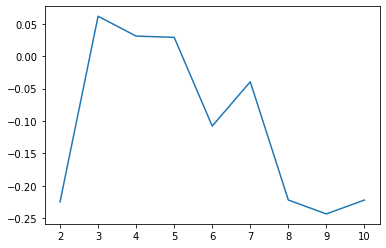

In [46]:
plt.plot(k_list, silhouette_list)
plt.show()

In [47]:
# Choose k=3
kmeans = KMeans(featuresCol='features', k=3).setDistanceMeasure('cosine')
model = kmeans.fit(final_data)

In [48]:
# Silhouette
predictions = model.transform(final_data)
# Evaluate
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print( 'Silhouette = '+ str(silhouette))

Silhouette = -0.006766548268247423


In [49]:
# results
centers = model.clusterCenters()
print('Cluster centers:')
for center in centers:
    print(center)

Cluster centers:
[0.08481103 0.06092642 0.21147933 ... 0.00121834 0.         0.        ]
[0.14753285 0.17096683 0.02943831 ... 0.         0.         0.00071037]
[0.03434489 0.07718621 0.0855955  ... 0.         0.00140824 0.        ]


In [50]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         2|
|         2|
|         0|
|         0|
|         2|
+----------+
only showing top 5 rows



In [51]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2296|
|         2| 1258|
|         0| 1249|
+----------+-----+



In [52]:
# Combine 2 df: predictions & filtered_data
predictions = predictions.withColumn('row_index', monotonically_increasing_id())
filtered_data = filtered_data.withColumn('row_index', monotonically_increasing_id())

data_prediction = filtered_data.join(predictions, on=['row_index']).sort('row_index').drop('row_index')

In [53]:
data_prediction = data_prediction.select('words_filtered', 'prediction')

In [54]:
data_prediction = data_prediction.withColumn("words_filtered",concat_ws(" ",col("words_filtered")))
data_prediction.show(3)

+--------------------+----------+
|      words_filtered|prediction|
+--------------------+----------+
|action adventure ...|         2|
|adventure fantasy...|         2|
|action adventure ...|         0|
+--------------------+----------+
only showing top 3 rows



In [55]:
# combine rows which have similar prediction
grouped_data = data_prediction.groupBy('prediction').agg(collect_list('words_filtered').alias("words_filtered"))
grouped_data.show(3)

+----------+--------------------+
|prediction|      words_filtered|
+----------+--------------------+
|         1|[drama romance th...|
|         2|[action adventure...|
|         0|[action adventure...|
+----------+--------------------+



In [56]:
grouped_data = grouped_data.withColumn("cluster_article", concat_ws(" ", "words_filtered"))
grouped_data.show(3)

+----------+--------------------+--------------------+
|prediction|      words_filtered|     cluster_article|
+----------+--------------------+--------------------+
|         1|[drama romance th...|drama romance thr...|
|         2|[action adventure...|action adventure ...|
|         0|[action adventure...|action adventure ...|
+----------+--------------------+--------------------+



In [57]:
cluster_data = grouped_data.select('cluster_article','prediction')
cluster_data.show(3)

+--------------------+----------+
|     cluster_article|prediction|
+--------------------+----------+
|drama romance thr...|         1|
|action adventure ...|         2|
|action adventure ...|         0|
+--------------------+----------+



In [58]:
# Get cluster 0
cluster0 = cluster_data.filter('prediction==0').select('cluster_article')
cluster0.show(3)

+--------------------+
|     cluster_article|
+--------------------+
|action adventure ...|
+--------------------+



In [59]:
# Get cluster 1
cluster1 = cluster_data.filter('prediction==1').select('cluster_article')
cluster1.show(3)

+--------------------+
|     cluster_article|
+--------------------+
|drama romance thr...|
+--------------------+



In [60]:
# Get cluster 2
cluster2 = cluster_data.filter('prediction==2').select('cluster_article')
cluster2.show(3)

+--------------------+
|     cluster_article|
+--------------------+
|action adventure ...|
+--------------------+



### Visualize using WordCloud

In [61]:
# Plot wordcloud
from wordcloud import WordCloud

In [62]:
# instantiate a word cloud object
wc0 = WordCloud(background_color='black', max_words=5000)
wc1 = WordCloud(background_color='black', max_words=5000)
wc2 = WordCloud(background_color='black', max_words=5000)

# generate the word cloud
wc_0 = wc0.generate(cluster0.toPandas().loc[0,'cluster_article']);
wc_1 = wc1.generate(cluster1.toPandas().loc[0,'cluster_article']);
wc_2 = wc2.generate(cluster2.toPandas().loc[0,'cluster_article']);

(-0.5, 399.5, 199.5, -0.5)

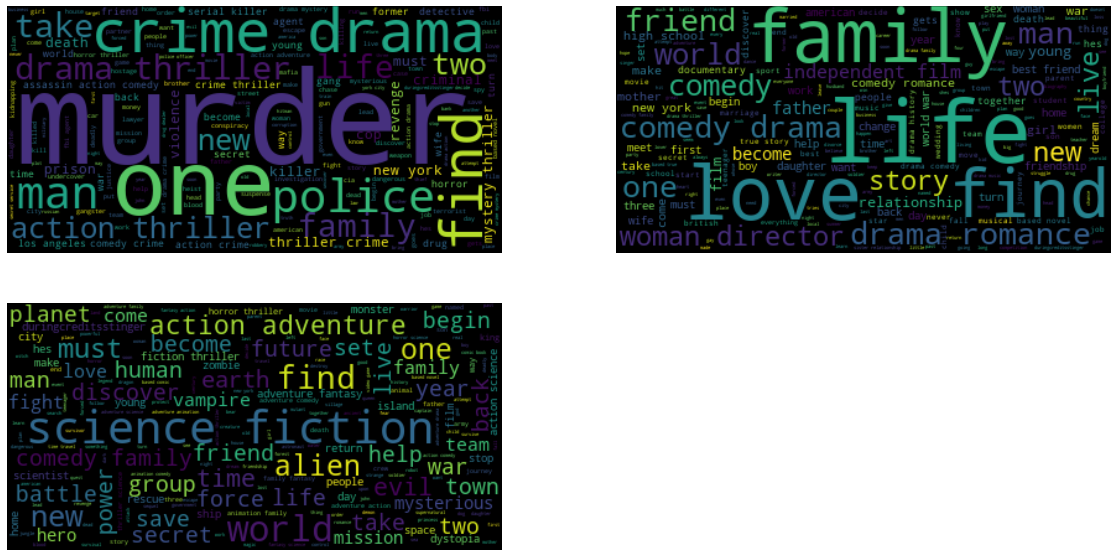

In [63]:
# display the word clouds
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(222)
plt.imshow(wc_1, interpolation='bilinear')
plt.axis('off')
plt.subplot(223)
plt.imshow(wc_2, interpolation='bilinear')
plt.axis('off')

- First cluster is movies about thriller, horror, crime, mystery
- Second cluster is movies about comedy, romance, family, love, relationship, drama
- Third cluster is movies about fiction, adventure, action, dystopia...